### Control law 

This notebook emulates a control laws where a set of 8 trucks are commanded to split at specific points in time. References to compute the platoon are in this case simulated not by a tactical strategy but virtually instead:

0. Setup model parameters (CAV)
1. Initial conditions for the model 
2. Reference conditions for the truck 
3. Launching the simulations for 

In [105]:
# %%writefile control.py
import numpy as np 
import pandas as pd 

# Plot 
import matplotlib.pyplot as plt 

import plotly as py 
from plotly.offline import init_notebook_mode, plot, iplot, iplot_mpl
import plotly.graph_objs as go 
init_notebook_mode(connected=True)


from ipywidgets import interactive, widgets
from IPython.display import display

#### Parameters

Simulation parameters

In [89]:
# %%writefile -a control.py
DT = 0.1 # Sample time 

Traffic parameters

In [88]:
# %%writefile -a control.py

# Truck parameters 
L_AVG = 18
G_X = 2
S_X = G_X + L_AVG
K_X = 1/S_X

# Physics
G = 9.81
MU = 0.02
M = 44.000
RHO = 1.2
A = 10 
CD = 0.7

# Traffic 
V_F = 25.0 # Max speed.
V_P = 20.0 # Platoon free flow
E  = 25.0*0.3 # Speed drop for relaxation 

U_MAX = 1.5 # Max. Acceleration
U_MIN = -1.5 # Min. Acceleration

Fundamental diagram settings, interactively done to illustrate behavior of influence of front-rear spacing `G_X` and capacity `C`

In [87]:
# %%writefile -a control.py

def compute_parameters(G_X, C):
    """ Compute dynamically parameters based on G_X,C"""
    S_X = L_AVG + G_X 
    K_X = 1 / S_X        
    K_C = C / V_P    
    W  = C / (K_X - K_C)
    return (S_X, K_X, K_C, W)


def compute_FD(G_X, C):
    """Compute data for some predefined parameters """
    
    def compute_FD(k):
        """Compute k,q vector: Piecewise FD"""
        free_branch = lambda x: V_P * x
        cong_branch = lambda x: - (x-K_X) * W
        flow = np.piecewise(k, [k < K_C, k >= K_C], [free_branch, cong_branch])
        
        return flow    
    
    S_X, K_X, K_C, W  = compute_parameters(G_X, C)
    
    k = np.linspace(0, K_X, 100)
    q = compute_FD(k)
    return (k,q)

def create_layout(K_X, C):
    """ Create figure layout """
    layout = go.Layout(title = 'FUNDAMENTAL DIAGRAM',
                       yaxis = dict(title = 'Q',
                                    range = [0, C],
                                   ),
                       xaxis = dict(title = 'k', 
                                    range = [0, K_X],
                                   ),
                       width = 600, 
                       height = 600,
                    )
    return layout

layout = create_layout(0.05, 1 * 3600)
    
def update_plot(fr_space, capacity):
    """ Update plot within the figure"""    
    
    k, q = compute_FD(fr_space, capacity/3600)
    

    
    data = []        
    
    trace = go.Scatter(
        x = k, 
        y = q * 3600,
        mode = 'lines',
        name = 'Fundamental diagram',
        line = dict(
            shape = 'spline'
        )
    )

    data.append(trace)
    
    fig = go.Figure(data = data, layout = layout)
    iplot(fig)
    

G_X_wg = widgets.FloatSlider(
        value=5,
        min=2,
        max=L_AVG-0.1,
        step=0.1,
        description='Front-rear Space gap',
        disabled=False,
        continuous_update=True,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
        )

C_wg  = widgets.FloatSlider(
        value=2400,
        min=1800,
        max=3600-10,
        step=5,
        description='Capacity',
        disabled=False,
        continuous_update=True,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
        )


interactive(update_plot, fr_space = G_X_wg, capacity = C_wg)

interactive(children=(FloatSlider(value=5.0, description='Front-rear Space gap', max=17.9, min=2.0, readout_fo…

In [86]:
# %%writefile -a control.py

G_X, C = G_X_wg.value, C_wg.value/3600
S_X, K_X, K_C, W  = compute_parameters(G_X, C)

TAU = 1/(K_X*W) # Time headway CAV 
RTE = TAU * (V_P+W) / V_P

# At capacity 
K = C/V_P
S_D = 1/K-L_AVG
G_T = S_D/V_P

Tau_wg = widgets.BoundedFloatText(
    value=TAU,
    min=0,
    max=10.0,
    step=0.1,
    description='Tau:',
    disabled=True
)
Rat_wg = widgets.BoundedFloatText(
    value=RTE,
    min=0,
    max=10.0,
    step=0.1,
    description='Rate:',
    disabled=True
)
gt_wg = widgets.BoundedFloatText(
    value=G_T,
    min=0,
    max=10.0,
    step=0.1,
    description='Inter (t):',
    disabled=True
)

gx_wg = widgets.BoundedFloatText(
    value=S_D,
    min=0,
    max=30.0,
    step=0.1,
    description='Inter (x):',
    disabled=True
)

display(Tau_wg)
display(Rat_wg)
display(gt_wg)
display(gx_wg)

BoundedFloatText(value=0.35, description='Tau:', disabled=True, max=10.0, step=0.1)

BoundedFloatText(value=1.5, description='Rate:', disabled=True, max=10.0, step=0.1)

BoundedFloatText(value=0.6, description='Inter (t):', disabled=True, max=10.0, step=0.1)

BoundedFloatText(value=12.0, description='Inter (x):', disabled=True, max=30.0, step=0.1)

In [85]:
# %%writefile -a control.py
fSimTime = 10 * 60 # seconds
nSamples = int(fSimTime*1/DT)
aTime = np.arange(nSamples)*DT

nHorizon = 50 # samples horizon

#### Initial conditions for the trucks 

In [84]:
# %%writefile -a control.py

nTrucks = 4
aDims = (nSamples, nTrucks)

State initialization, space, speed, delta speed leader 

In [83]:
# %%writefile -a control.py

def set_initial_condition(mS0, mV0, mDV0):
    """ Setup initial conditions of experiment"""
    mS = np.zeros(aDims) # Spacing all trucks
    mV = np.zeros(aDims) # Speed 
    mDV = np.zeros(aDims) # Speed diference
    mS[0,:] = mS0
    mV[0,:] = mV0
    mDV[0,:]= mDV0
    return (mS, mV, mDV)

In [82]:
# %%writefile -a control.py
mS0 = np.ones(nTrucks) * (S_D + L_AVG) 
mV0 = np.ones(nTrucks) * V_P
mDV0 = np.zeros(nTrucks)

mS, mV, mDV = set_initial_condition(mS0, mV0, mDV0)

#### Reference conditions for trucks


In [91]:
# %%writefile -a control.py 

iYieldTruck = range(1, nTrucks)

# Splits are predefined at some specific points in time (merging times)
iIdxTimeSplit = [int(t*60*1/DT) for t in (3,6,9)]
fTimeSplit = [aTime[i] for i in iIdxTimeSplit ]
fValueTimeHwyInitial = [G_T]
fValueTimeHwyEnd = [2*G_T]
fValueTimeHwy = [(st,ed) for st, ed in zip(fValueTimeHwyInitial,fValueTimeHwyEnd)]


mEvents = [{'id':i, 'tm': tm, 'tg': tg} for i in iYieldTruck for tm in fTimeSplit for tg in fValueTimeHwy]


To do:

* Create a scenario (2 splits and reintegrations)  - Func
* Run a single simulation Func( initial_cond, leaders_acc, theta) 

In [93]:
# %%writefile -a control.py 

def create_ref(dEvent, Teq):
    """Creates a reference matrix for the control"""
    
    def anticipation_time(T_0, T_F):
        """Computes the anticipation time according to TRB 2018"""
        T_a = E / 2 * (U_MIN-U_MAX)/ (U_MIN * U_MAX) + (V_P + W) / E * (T_F - T_0)
        return T_a    
    
    def get_sigmoid(v0, vf, yld, ant):
        """ Computes a sigmoid function with rise time equivalent to anticipation time"""
        aNewTime = 8 * (aTime - (yld + ant/2)) / ant
        return v0 + (vf-v0) * 1 / (1 + np.exp(- aNewTime))
    
    mRef = np.ones(aDims) * Teq
    iIdTruck = dEvent['id']
    fMrgTime = dEvent['tm']
    T_0, T_X = dEvent['tg']
    _T_0, _T_X = (T_X, T_0) if T_0 > T_X else (T_0, T_X)
    fAntTime = anticipation_time(_T_0, _T_X)
    fYldTime = fMrgTime - fAntTime
    
    mRef[:,iIdTruck] = get_sigmoid(T_0, T_X, fYldTime, fAntTime)        
    
    print(f'Anticipation time: {fAntTime}')
    print(f'Yielding time: {fYldTime}')
    
    return mRef

In [96]:
# %%writefile -a control.py

mRef = create_ref(mEvents[0], G_T)

Anticipation time: 11.857142857142858
Yielding time: 168.14285714285714


### Control design 

Control parameters

In [97]:
# %%writefile -a control.py 

C1 = 0.1
C2 = 1
C3 = 0.5

Internal functions for the control 

In [99]:
# %%writefile -a control.py 

def initialize_mpc(mS0, mV0, mDV0):
    """ Initialize internal variables control"""
    aDimMPC = (nHorizon,nTrucks)
    m_S, m_V, m_DV, m_LS, m_LV, m_U = (np.zeros(aDimMPC) for i in range(6))
    m_S[0] = mS0
    m_V[0] = mV0
    m_DV[0] = mDV0
    return m_S, m_V, m_DV, m_LS, m_LV, m_U

def update_cd(s):
    """ Updates the drag coefficient"""
    s[0] = L_AVG # Accounts for leader not saving
    fCD = (1-np.exp(-2 * s/ L_AVG))/2 + 0.42
    return fCD

def update_grad_cd(s):
    """ Updates the drag coefficient"""
    s[0] = L_AVG # Accounts for leader not saving
    fCD = np.exp(-2 * s/ L_AVG)/ (2 * L_AVG) 
    return fCD

def forward_evolution(X, U, D):        
    """ Compute forward model evolution
        X : S, V, DV 
        U : control 
        D : slope
    """

    S, V, DV = X
    
    cordim = lambda x: x.shape if len(x.shape)>1 else (1,x.shape[0])
    
    U = U.reshape(cordim(U))
    
    DU = np.concatenate((np.zeros((U.shape[0],1)), 
                         U[:,0:-1] + U[:,1:]), 
                        axis = 1)

    run = zip(U, DU, D)

    K1 = G * MU
    K2 = G
    K3 = RHO * A * CD / (2 * M)

    for i, u in enumerate(run):
        u_s, du, theta  = u
        if i < len(S)-1:
            print(du)
            print(DV)
            DV[i+1] = DV[i] + DT * du
            S[i+1] = S[i] + DT * DV[i]
            mfac = u_s - K1 - K2 * theta\
                   - K3 * update_cd(S[i]) * V[i]**2
            V[i+1] = V[i] + DT * mfac
    return S, V, DV           

def backward_evolution(X, Ref):
    """ Compute  bakckward costate evolution
        L : LS, LV 
        X : S, V, DV
    """    
    
    def reversedEnumerate(*args):
        """ Inverse enumeration iterator"""
        revArg = [np.flip(x, axis=0) for x in args]
        return zip(range(len(args[0])-1, -1, -1), *revArg)

    S, V, DV = X
    
    aDimMPC = (nHorizon,nTrucks)
    ls = np.zeros(aDimMPC)
    lv = np.zeros(aDimMPC)
    
    runinv = reversedEnumerate(S, V, DV, Ref)
    
    K3 = RHO * A * CD / (2 * M)
    
    for i, s, v, dv, tg in runinv:
        if i > 0:
            sref = v * tg + L_AVG
            lv[i-1] = lv[i] + DT * (-2 * C1 * (s-sref) * tg \
                                    - C2 * dv - ls[i]\
                                    - lv[i] * K3 * update_cd(s)
                                   )
            ls[i-1] = ls[i] + DT * (2 * C1 * (s-sref)\
                                    - lv[i] * K3 * update_grad_cd(s) * (v ** 2)
                                   )                

    return ls, lv

Control routine

In [101]:
# %%writefile -a control.py 

def compute_control(mX0, mRef, mTheta):
    """ Computes a control based on mX0 and the reference mRef"""
    
    _m_S, _m_V, _m_DV, _m_LS, _m_LV, m_U = initialize_mpc(*mX0)
    _X = (_m_S, _m_V, _m_DV)
    
    # Parameters

    ALPHA = 0.01
    EPS = 0.1
    
    # Convergence
    error = 100
    bSuccess = 2
    N = 10000  # number of iterations
    
    step = iter(range(N)) 
    n = 0
    n_prev = 0
    
    while (error > EPS) and (bSuccess > 0):
        try:
            next(step)
            
            U_star = -_m_LV /(2 * C3)          
            
            U_star = np.clip(U_star, U_MIN, U_MAX)

            _m_S, _m_V, _m_DV = forward_evolution(_X, U_star, mTheta)                         

            _lS, _lV = backward_evolution(_X, mRef)
            
            _m_LS = (1 - ALPHA) * _m_LS + ALPHA * _lS
            _m_LV = (1 - ALPHA) * _m_LV + ALPHA * _lV
            
            
            error = np.linalg.norm(_m_LS - _lS) + \
                    np.linalg.norm(_m_LV - _lV)
            

            # print(f'Error:{error}')
            # Routine for changing convergence parameter

            if error > 10e5:
                raise AssertionError('Algorithm does not converge ')
            if n >= 500:
                ALPHA = max(ALPHA - 0.01, 0.01)
                print(f'Reaching {n} iterations: Reducing alpha: {ALPHA}')
                print(f'Error before update {error}')
                if n > 10000:
                    raise AssertionError(
                        'Maximum iterations reached by the algorithm')
                n_prev = n + n_prev
                n = 0
            if error <= EPS:
                bSuccess = 0

            n += 1

        except StopIteration:
            print('Stop by iteration')
            print('Last simulation step at iteration: {}'.format(n+n_prev))
            bSuccess = 0

    n = n + n_prev
    print(f'Total it:{n}')
    
    return U_star[0]

Control test 

In [ ]:
# %%writefile -a control.py 

mRefW = G_T*np.ones((nHorizon,nTrucks))
mTheta = np.zeros(mRefW.shape)

for i, x in enumerate(mRef):

    if i < len(mRef)-1:

        aX = (mS[i], mV[i], mDV[i])
    
        aU = compute_control(aX, mRefW, mTheta)
    
        mS[i+1], mV[i+1], mDV[i+1] = forward_evolution(aX, aU, mTheta)
    
    
    
    

# Test zone

In [138]:
x = pd.read_csv('../output/space.csv', delimiter='\t')
u = pd.read_csv('../output/control.csv', delimiter='\t')
r = pd.read_csv('../output/ref.csv', delimiter='\t')

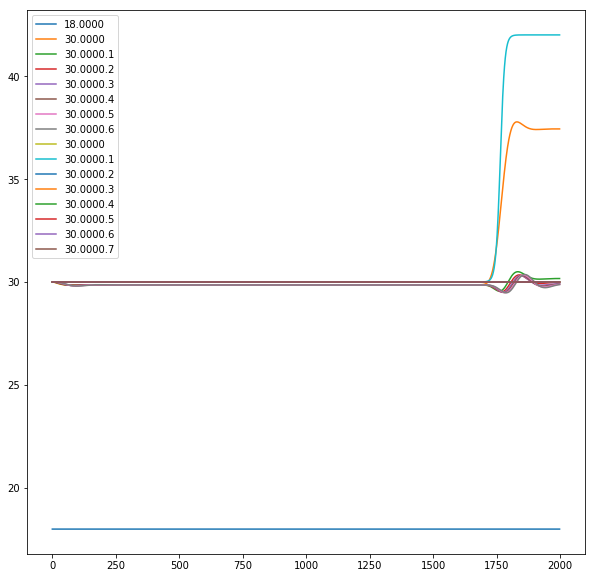

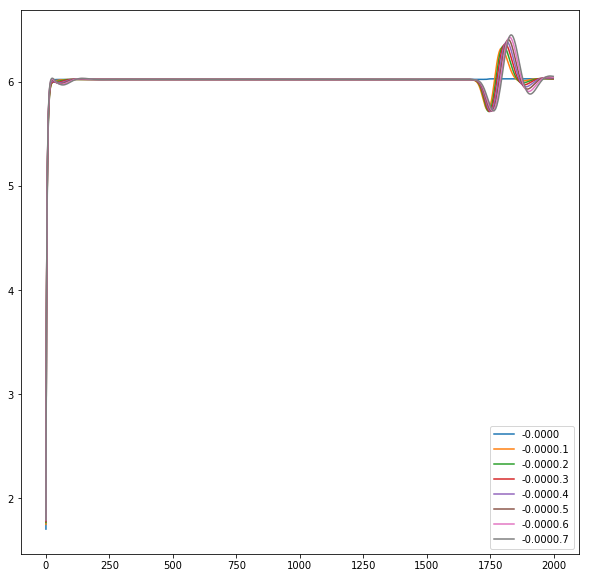

In [139]:
plt.figure(figsize= (10,10))
ax1 = plt.gca()
x.iloc[0:1999].plot(ax=ax1)
r.iloc[0:1999].plot(ax=ax1)
plt.figure(figsize= (10,10))
ax1 = plt.gca()
u.iloc[0:1999].plot(ax=ax1)

Math tests 

In [47]:
from sympy import * 
import math 

In [45]:
init_printing(use_latex = 'mathjax')

In [64]:
s, L, K = symbols('s L K')

In [72]:
y = (1-exp(-2 * s/ L))/2+K

In [51]:
diff(_, s)

 -2⋅s 
 ─────
   L  
ℯ     
──────
  L   

In [53]:
Integral(sin(s), (s,0,pi))

π          
⌠          
⎮ sin(s) ds
⌡          
0          